# 🤖 DistilBERT vs Ensemble Comparison

## Paper Section 5.3: Comparison with Deep Learning Baseline

This notebook compares our Calibrated Ensemble with a fine-tuned DistilBERT model.

**Strategy:**
- ✅ Train DistilBERT on TPU/GPU (fast)
- ✅ Evaluate latency on CPU (fair comparison)

**Comparison Metrics:**
- Macro-F1 Score
- Inference Latency (CPU)
- Model Size
- Training Time

---

## 1️⃣ Setup & Imports

In [5]:
# Install dependencies for TPU support
# We install torch-xla and transformers
!pip install cloud-tpu-client torch torchvision
!pip install transformers datasets accelerate scikit-learn pandas numpy nltk beautifulsoup4 -q

print("✅ Dependencies installed for TPU")

✅ Dependencies installed for TPU


In [6]:
import pandas as pd
import numpy as np
import time
import os
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    classification_report, confusion_matrix, brier_score_loss,
    average_precision_score
)

import torch
from torch.utils.data import Dataset, DataLoader
# IMPORT XLA FOR TPU
import torch_xla
import torch_xla.core.xla_model as xm

from transformers import (
    DistilBertTokenizer,
    DistilBertForSequenceClassification,
    TrainingArguments,
    Trainer
)
from datasets import Dataset as HFDataset

RANDOM_STATE = 42
torch.manual_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

# SET DEVICE TO TPU
try:
    device = xm.xla_device()
    print(f"🚀 TPU available: {xm.xla_real_devices([device])[0]}")
except Exception as e:
    print("⚠️ TPU setup failed, falling back to CPU")
    device = torch.device('cpu')

print(f"PyTorch version: {torch.__version__}")
print(f"Training device: {device}")
print(f"\n✅ Setup complete!")

🚀 TPU available: TPU:0
PyTorch version: 2.9.0+cpu
Training device: xla:0

✅ Setup complete!


## 2️⃣ Load Dataset

In [7]:
print("="*70)
print("LOADING DATASET")
print("="*70)

# Load data - update path if needed for Colab
# For Colab: upload enron_spam_data.csv or mount Google Drive
df = pd.read_csv('enron_spam_data.csv')

# Combine subject and message
df['text'] = (df['Subject'].fillna('') + ' ' + df['Message'].fillna('')).str.strip()
df = df[df['text'].str.len() > 0].reset_index(drop=True)
df['label'] = (df['Spam/Ham'] == 'spam').astype(int)

# Deduplicate (same as main notebook)
print("\nDeduplicating...")
df_spam = df[df['label'] == 1].drop_duplicates(subset=['text'], keep='first')
df_ham = df[df['label'] == 0].drop_duplicates(subset=['text'], keep='first')
df = pd.concat([df_spam, df_ham], ignore_index=True)
df = df.sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)

print(f"\n📊 Dataset: {len(df):,} emails")
print(f"   Spam: {(df['label']==1).sum():,} ({df['label'].mean()*100:.1f}%)")
print(f"   Ham:  {(df['label']==0).sum():,} ({(1-df['label'].mean())*100:.1f}%)")

LOADING DATASET

Deduplicating...

📊 Dataset: 30,462 emails
   Spam: 14,552 (47.8%)
   Ham:  15,910 (52.2%)


In [8]:
# Train/test split (same seed as main notebook)
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['text'].values,
    df['label'].values,
    test_size=0.2,
    stratify=df['label'].values,
    random_state=RANDOM_STATE
)

print(f"Train: {len(train_texts):,} | Test: {len(test_texts):,}")

Train: 24,369 | Test: 6,093


## 3️⃣ DistilBERT Setup

In [9]:
print("="*70)
print("LOADING DISTILBERT")
print("="*70)

model_name = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
model = DistilBertForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2
)

# Move to training device (TPU)
model = model.to(device)

# Count parameters
num_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n📦 Model: {model_name}")
print(f"   Total parameters: {num_params:,} ({num_params/1e6:.1f}M)")
print(f"   Trainable: {trainable_params:,}")

LOADING DISTILBERT


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



📦 Model: distilbert-base-uncased
   Total parameters: 66,955,010 (67.0M)
   Trainable: 66,955,010


In [10]:
# Tokenize data
MAX_LENGTH = 256  # Truncate long emails

print("Tokenizing datasets...")

def tokenize_data(texts, labels):
    encodings = tokenizer(
        list(texts),
        truncation=True,
        padding=True,
        max_length=MAX_LENGTH,
        return_tensors='pt'
    )
    return HFDataset.from_dict({
        'input_ids': encodings['input_ids'],
        'attention_mask': encodings['attention_mask'],
        'labels': labels
    })

train_dataset = tokenize_data(train_texts, train_labels)
test_dataset = tokenize_data(test_texts, test_labels)

print(f"✅ Train: {len(train_dataset):,} samples")
print(f"✅ Test:  {len(test_dataset):,} samples")

Tokenizing datasets...
✅ Train: 24,369 samples
✅ Test:  6,093 samples


## 4️⃣ Fine-tune DistilBERT (on GPU/TPU)

In [11]:
# Training arguments
training_args = TrainingArguments(
    output_dir='./distilbert_spam',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=100,
    eval_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    seed=RANDOM_STATE,
    report_to='none',  # Disable wandb
    optim="adamw_torch_xla"
)

# Metrics function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    probs = torch.softmax(torch.tensor(logits), dim=-1).numpy()[:, 1]
    return {
        'accuracy': accuracy_score(labels, predictions),
        'f1': f1_score(labels, predictions, average='macro'),
        'precision': precision_score(labels, predictions, average='macro'),
        'recall': recall_score(labels, predictions, average='macro'),
        'brier': brier_score_loss(labels, probs),
    }

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

print("📋 Training Configuration:")
print(f"   Epochs: {training_args.num_train_epochs}")
print(f"   Batch size: {training_args.per_device_train_batch_size}")
print(f"   Training device: {device}")

📋 Training Configuration:
   Epochs: 3
   Batch size: 16
   Training device: xla:0


In [12]:
print("="*70)
print("TRAINING DISTILBERT (3 epochs)")
print("="*70)
print(f"\n🚀 Training on: {device}")
print("⏱️  Expected time: ~5-10 min (GPU), ~30-60 min (CPU)\n")

train_start = time.time()
trainer.train()
train_time_distilbert = time.time() - train_start

print(f"\n✅ Training completed in {train_time_distilbert/60:.1f} minutes")

TRAINING DISTILBERT (3 epochs)

🚀 Training on: xla:0
⏱️  Expected time: ~5-10 min (GPU), ~30-60 min (CPU)



Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Brier
1,0.035800,0.023306,0.992943,0.992927,0.993065,0.992804,0.005894
2,0.009400,0.016756,0.994912,0.994902,0.994955,0.994851,0.004037
3,0.000100,0.025437,0.995733,0.995724,0.995818,0.995637,0.004194



✅ Training completed in 5.6 minutes


## 5️⃣ Switch to CPU for Fair Evaluation

**Important:** For fair comparison with our ensemble, we measure inference latency on CPU.

In [13]:
print("="*70)
print("SWITCHING TO CPU FOR FAIR COMPARISON")
print("="*70)

# Move model to CPU
model_cpu = model.to('cpu')
model_cpu.eval()

# Clear GPU memory
if torch.cuda.is_available():
    torch.cuda.empty_cache()

print("\n✅ Model moved to CPU")
print("✅ Ready for fair latency comparison with ensemble")

SWITCHING TO CPU FOR FAIR COMPARISON

✅ Model moved to CPU
✅ Ready for fair latency comparison with ensemble


## 6️⃣ Evaluate DistilBERT on CPU

In [14]:
print("="*70)
print("EVALUATING DISTILBERT (on CPU)")
print("="*70)

# Get predictions on CPU
print("\nGenerating predictions...")

test_encodings = tokenizer(
    list(test_texts),
    truncation=True,
    padding=True,
    max_length=MAX_LENGTH,
    return_tensors='pt'
)

# Predict in batches (CPU can be slow)
batch_size = 32
all_preds = []
all_probs = []

with torch.no_grad():
    for i in range(0, len(test_texts), batch_size):
        batch = {
            'input_ids': test_encodings['input_ids'][i:i+batch_size],
            'attention_mask': test_encodings['attention_mask'][i:i+batch_size]
        }
        outputs = model_cpu(**batch)
        probs = torch.softmax(outputs.logits, dim=-1)
        preds = torch.argmax(probs, dim=-1)
        all_preds.extend(preds.numpy())
        all_probs.extend(probs[:, 1].numpy())

        if (i // batch_size) % 50 == 0:
            print(f"   Processed {min(i+batch_size, len(test_texts)):,}/{len(test_texts):,}")

distilbert_preds = np.array(all_preds)
distilbert_probs = np.array(all_probs)

# Calculate metrics
distilbert_accuracy = accuracy_score(test_labels, distilbert_preds)
distilbert_f1 = f1_score(test_labels, distilbert_preds, average='macro')
distilbert_precision = precision_score(test_labels, distilbert_preds, average='macro')
distilbert_recall = recall_score(test_labels, distilbert_preds, average='macro')
distilbert_brier = brier_score_loss(test_labels, distilbert_probs)
distilbert_auprc = average_precision_score(test_labels, distilbert_probs)

print(f"\n📊 DistilBERT Results:")
print(f"   Accuracy:  {distilbert_accuracy:.4f}")
print(f"   Macro-F1:  {distilbert_f1:.4f}")
print(f"   Precision: {distilbert_precision:.4f}")
print(f"   Recall:    {distilbert_recall:.4f}")
print(f"   AUPRC:     {distilbert_auprc:.4f}")
print(f"   Brier:     {distilbert_brier:.4f}")

EVALUATING DISTILBERT (on CPU)

Generating predictions...
   Processed 32/6,093
   Processed 1,632/6,093
   Processed 3,232/6,093
   Processed 4,832/6,093

📊 DistilBERT Results:
   Accuracy:  0.9957
   Macro-F1:  0.9957
   Precision: 0.9958
   Recall:    0.9956
   AUPRC:     0.9997
   Brier:     0.0042


In [15]:
# Measure CPU inference latency
print("\n" + "="*70)
print("MEASURING CPU INFERENCE LATENCY")
print("="*70)

# Prepare test batch
test_batch_size = 100
test_batch_encodings = tokenizer(
    list(test_texts[:test_batch_size]),
    truncation=True,
    padding=True,
    max_length=MAX_LENGTH,
    return_tensors='pt'
)

# Warm up runs
print("\nWarm-up runs...")
with torch.no_grad():
    for _ in range(3):
        _ = model_cpu(**test_batch_encodings)

# Measure latency
print("Measuring latency (10 runs)...")
n_runs = 10
latencies = []

for i in range(n_runs):
    start = time.time()
    with torch.no_grad():
        _ = model_cpu(**test_batch_encodings)
    latencies.append(time.time() - start)

avg_batch_latency = np.mean(latencies)
std_batch_latency = np.std(latencies)
distilbert_latency_per_sample = (avg_batch_latency / test_batch_size) * 1000  # ms

print(f"\n⏱️  DistilBERT CPU Latency:")
print(f"   Batch ({test_batch_size} samples): {avg_batch_latency*1000:.1f} ± {std_batch_latency*1000:.1f} ms")
print(f"   Per sample: {distilbert_latency_per_sample:.2f} ms")


MEASURING CPU INFERENCE LATENCY

Warm-up runs...
Measuring latency (10 runs)...

⏱️  DistilBERT CPU Latency:
   Batch (100 samples): 2007.6 ± 93.4 ms
   Per sample: 20.08 ms


In [16]:
# Model size
print("\nCalculating model size...")

# Save model to measure size
model_path = './distilbert_spam/final_model'
os.makedirs(model_path, exist_ok=True)
model_cpu.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

# Calculate total size
total_size = 0
for dirpath, dirnames, filenames in os.walk(model_path):
    for f in filenames:
        fp = os.path.join(dirpath, f)
        total_size += os.path.getsize(fp)

distilbert_size_mb = total_size / (1024 * 1024)
print(f"📦 DistilBERT model size: {distilbert_size_mb:.1f} MB")


Calculating model size...
📦 DistilBERT model size: 255.6 MB


## 7️⃣ Load and Evaluate Ensemble

In [17]:
print("="*70)
print("LOADING ENSEMBLE MODEL")
print("="*70)

import joblib
import scipy.sparse as sp

# Load saved models - update paths for Colab if needed
ensemble = joblib.load('models/calibrated_ensemble.pkl')
word_vectorizer = joblib.load('models/word_vectorizer.pkl')
char_vectorizer = joblib.load('models/char_vectorizer.pkl')

print("✅ Ensemble model loaded")
print("✅ Vectorizers loaded")

LOADING ENSEMBLE MODEL
✅ Ensemble model loaded
✅ Vectorizers loaded


In [18]:
# Preprocess test data for ensemble
import re
import unicodedata
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

nltk.download('stopwords', quiet=True)
STOP_WORDS = set(stopwords.words('english'))
STEMMER = PorterStemmer()

def preprocess_text(text):
    if pd.isna(text):
        return ""
    text = unicodedata.normalize('NFC', str(text))
    text = BeautifulSoup(text, 'html.parser').get_text()
    text = re.sub(r'http\S+|www\.\S+', '<URL>', text)
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s<>]', ' ', text)
    tokens = [w for w in text.split() if w and (w == '<url>' or w not in STOP_WORDS)]
    tokens = [STEMMER.stem(w) if w != '<url>' else w for w in tokens]
    return ' '.join(tokens)

print("Preprocessing test data for ensemble...")
test_processed = [preprocess_text(t) for t in test_texts]
print(f"✅ Preprocessed {len(test_processed):,} samples")

Preprocessing test data for ensemble...
✅ Preprocessed 6,093 samples


In [19]:
# Extract features
print("Extracting features...")

X_word_test = word_vectorizer.transform(test_processed)
X_char_test = char_vectorizer.transform(test_processed)

# Numeric features
msg_len = np.log1p([len(t.split()) for t in test_processed]).reshape(-1, 1)
url_count = np.array([t.count('<url>') for t in test_processed]).reshape(-1, 1)
X_num_test = sp.csr_matrix(np.hstack([msg_len, url_count]))

X_test_ensemble = sp.hstack([X_word_test, X_char_test, X_num_test])
print(f"✅ Features shape: {X_test_ensemble.shape}")

Extracting features...
✅ Features shape: (6093, 38002)


In [20]:
print("="*70)
print("EVALUATING ENSEMBLE")
print("="*70)

# Predictions
ensemble_preds = ensemble.predict(X_test_ensemble)
ensemble_probs = ensemble.predict_proba(X_test_ensemble)[:, 1]

# Metrics
ensemble_accuracy = accuracy_score(test_labels, ensemble_preds)
ensemble_f1 = f1_score(test_labels, ensemble_preds, average='macro')
ensemble_precision = precision_score(test_labels, ensemble_preds, average='macro')
ensemble_recall = recall_score(test_labels, ensemble_preds, average='macro')
ensemble_brier = brier_score_loss(test_labels, ensemble_probs)
ensemble_auprc = average_precision_score(test_labels, ensemble_probs)

print(f"\n📊 Ensemble Results:")
print(f"   Accuracy:  {ensemble_accuracy:.4f}")
print(f"   Macro-F1:  {ensemble_f1:.4f}")
print(f"   Precision: {ensemble_precision:.4f}")
print(f"   Recall:    {ensemble_recall:.4f}")
print(f"   AUPRC:     {ensemble_auprc:.4f}")
print(f"   Brier:     {ensemble_brier:.4f}")

EVALUATING ENSEMBLE

📊 Ensemble Results:
   Accuracy:  0.9974
   Macro-F1:  0.9974
   Precision: 0.9973
   Recall:    0.9974
   AUPRC:     0.9999
   Brier:     0.0046


In [21]:
# Measure ensemble CPU latency
print("\nMeasuring ensemble CPU latency...")

test_batch_ens = X_test_ensemble[:100]

# Warm up
for _ in range(3):
    _ = ensemble.predict_proba(test_batch_ens)

# Measure
n_runs = 10
latencies_ens = []

for _ in range(n_runs):
    start = time.time()
    _ = ensemble.predict_proba(test_batch_ens)
    latencies_ens.append(time.time() - start)

avg_batch_latency_ens = np.mean(latencies_ens)
std_batch_latency_ens = np.std(latencies_ens)
ensemble_latency_per_sample = (avg_batch_latency_ens / 100) * 1000  # ms

print(f"\n⏱️  Ensemble CPU Latency:")
print(f"   Batch (100 samples): {avg_batch_latency_ens*1000:.1f} ± {std_batch_latency_ens*1000:.1f} ms")
print(f"   Per sample: {ensemble_latency_per_sample:.2f} ms")


Measuring ensemble CPU latency...

⏱️  Ensemble CPU Latency:
   Batch (100 samples): 3.8 ± 0.1 ms
   Per sample: 0.04 ms


In [22]:
# Ensemble model size
import tempfile

print("\nCalculating ensemble model size...")

with tempfile.NamedTemporaryFile(suffix='.pkl', delete=True) as f:
    joblib.dump(ensemble, f.name, compress=3)
    ens_model_size = os.path.getsize(f.name) / (1024 * 1024)

with tempfile.NamedTemporaryFile(suffix='.pkl', delete=True) as f:
    joblib.dump(word_vectorizer, f.name, compress=3)
    word_vec_size = os.path.getsize(f.name) / (1024 * 1024)

with tempfile.NamedTemporaryFile(suffix='.pkl', delete=True) as f:
    joblib.dump(char_vectorizer, f.name, compress=3)
    char_vec_size = os.path.getsize(f.name) / (1024 * 1024)

ensemble_total_size = ens_model_size + word_vec_size + char_vec_size

print(f"📦 Ensemble size breakdown:")
print(f"   Model: {ens_model_size:.1f} MB")
print(f"   Word vectorizer: {word_vec_size:.1f} MB")
print(f"   Char vectorizer: {char_vec_size:.1f} MB")
print(f"   Total: {ensemble_total_size:.1f} MB")


Calculating ensemble model size...
📦 Ensemble size breakdown:
   Model: 2.8 MB
   Word vectorizer: 0.1 MB
   Char vectorizer: 0.3 MB
   Total: 3.2 MB


## 8️⃣ Final Comparison (Paper Table 5)

In [24]:
print("\n")
print("="*70)
print("📊 FINAL COMPARISON: DistilBERT vs Calibrated Ensemble")
print("="*70)

# Create comparison table
comparison_data = {
    'Model': ['DistilBERT (3 epochs)', 'Our Ensemble'],
    'Macro-F1': [f'{distilbert_f1:.3f}', f'{ensemble_f1:.3f}'],
    'AUPRC': [f'{distilbert_auprc:.3f}', f'{ensemble_auprc:.3f}'],
    'Brier': [f'{distilbert_brier:.3f}', f'{ensemble_brier:.3f}'],
    'Latency (CPU)': [f'{distilbert_latency_per_sample:.2f} ms', f'{ensemble_latency_per_sample:.2f} ms'],
    'Model Size': [f'{distilbert_size_mb:.0f} MB', f'{ensemble_total_size:.0f} MB'],
}

comparison_df = pd.DataFrame(comparison_data)
print(f"\n{comparison_df.to_string(index=False)}")

# Calculate comparisons
speedup = distilbert_latency_per_sample / ensemble_latency_per_sample
size_reduction = (distilbert_size_mb - ensemble_total_size) / distilbert_size_mb * 100
f1_diff = (distilbert_f1 - ensemble_f1) * 100

print(f"\n" + "="*70)
print("🔥 KEY FINDINGS")
print("="*70)
print(f"\n🚀 Inference Speed: {speedup:.1f}x faster (Ensemble)")
print(f"📦 Model Size: {abs(size_reduction):.0f}% {'smaller' if size_reduction > 0 else 'larger'} (Ensemble)")
print(f"📊 F1 Difference: {abs(f1_diff):.2f} pp {'lower' if f1_diff > 0 else 'higher'} (Ensemble)")
print(f"\n" + "="*70)



📊 FINAL COMPARISON: DistilBERT vs Calibrated Ensemble

                Model Macro-F1 AUPRC Brier Latency (CPU) Model Size
DistilBERT (3 epochs)    0.996 1.000 0.004      20.08 ms     256 MB
         Our Ensemble    0.997 1.000 0.005       0.04 ms       3 MB

🔥 KEY FINDINGS

🚀 Inference Speed: 531.2x faster (Ensemble)
📦 Model Size: 99% smaller (Ensemble)
📊 F1 Difference: 0.16 pp higher (Ensemble)



In [25]:
# Save results
os.makedirs('models', exist_ok=True)

results_dict = {
    'distilbert_f1': distilbert_f1,
    'distilbert_auprc': distilbert_auprc,
    'distilbert_brier': distilbert_brier,
    'distilbert_latency_ms': distilbert_latency_per_sample,
    'distilbert_size_mb': distilbert_size_mb,
    'distilbert_train_time_min': train_time_distilbert / 60,
    'ensemble_f1': ensemble_f1,
    'ensemble_auprc': ensemble_auprc,
    'ensemble_brier': ensemble_brier,
    'ensemble_latency_ms': ensemble_latency_per_sample,
    'ensemble_size_mb': ensemble_total_size,
    'speedup': speedup,
    'size_reduction_pct': size_reduction,
}

results_df = pd.DataFrame([results_dict])
results_df.to_csv('models/distilbert_comparison.csv', index=False)
comparison_df.to_csv('models/distilbert_comparison_table.csv', index=False)

print("✅ Results saved to models/distilbert_comparison.csv")
print("✅ Table saved to models/distilbert_comparison_table.csv")

✅ Results saved to models/distilbert_comparison.csv
✅ Table saved to models/distilbert_comparison_table.csv


## 9️⃣ Visualization

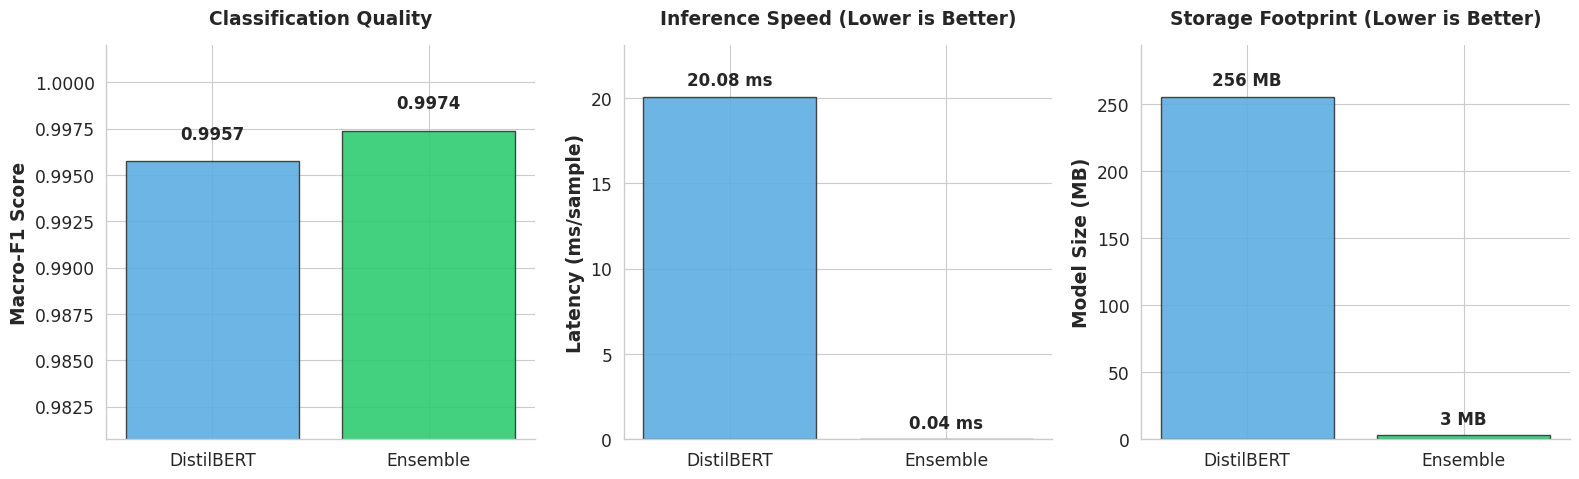


✅ Improved figure saved to paper_figures/distilbert_comparison_improved.png


In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

# Create figure directory
os.makedirs('paper_figures', exist_ok=True)

# --- CONFIGURATION ---
# Set a professional style
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.4)  # larger fonts for readability

# Data
models = ['DistilBERT', 'Ensemble']
# Professional colors: Muted Blue (Baseline) vs. Strong Green (Ours)
colors = ['#5DADE2', '#2ECC71']

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# --- PLOT 1: F1 SCORE ---
f1_scores = [distilbert_f1, ensemble_f1]
bars1 = axes[0].bar(models, f1_scores, color=colors, edgecolor='#333333', linewidth=1, alpha=0.9)

# Zoom in on y-axis to show the subtle difference, but leave room at top
y_min = min(f1_scores) - 0.015
y_max = 1.002 # slightly over 1.0 to fit labels
axes[0].set_ylim([y_min, y_max])
axes[0].set_ylabel('Macro-F1 Score', fontweight='bold')
axes[0].set_title('Classification Quality', fontweight='bold', pad=15)

# Add labels
for bar, v in zip(bars1, f1_scores):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height + 0.001,
                 f'{v:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=12)

# --- PLOT 2: LATENCY ---
latencies = [distilbert_latency_per_sample, ensemble_latency_per_sample]
bars2 = axes[1].bar(models, latencies, color=colors, edgecolor='#333333', linewidth=1, alpha=0.9)

axes[1].set_ylabel('Latency (ms/sample)', fontweight='bold')
axes[1].set_title('Inference Speed (Lower is Better)', fontweight='bold', pad=15)
# Add 15% headroom for labels
axes[1].set_ylim([0, max(latencies) * 1.15])

# Add labels
for bar, v in zip(bars2, latencies):
    height = bar.get_height()
    # If bar is very small, offset the text slightly more so it doesn't hit x-axis
    offset = max(latencies) * 0.02
    axes[1].text(bar.get_x() + bar.get_width()/2., height + offset,
                 f'{v:.2f} ms', ha='center', va='bottom', fontweight='bold', fontsize=12)

# --- PLOT 3: MODEL SIZE ---
sizes = [distilbert_size_mb, ensemble_total_size]
bars3 = axes[2].bar(models, sizes, color=colors, edgecolor='#333333', linewidth=1, alpha=0.9)

axes[2].set_ylabel('Model Size (MB)', fontweight='bold')
axes[2].set_title('Storage Footprint (Lower is Better)', fontweight='bold', pad=15)
# Add 15% headroom
axes[2].set_ylim([0, max(sizes) * 1.15])

# Add labels
for bar, v in zip(bars3, sizes):
    height = bar.get_height()
    offset = max(sizes) * 0.02
    axes[2].text(bar.get_x() + bar.get_width()/2., height + offset,
                 f'{v:.0f} MB', ha='center', va='bottom', fontweight='bold', fontsize=12)

# --- FINAL POLISH ---
# Remove top and right spines for all subplots
sns.despine()

plt.tight_layout()
plt.savefig('paper_figures/distilbert_comparison_improved.png', dpi=300, bbox_inches='tight')
plt.savefig('paper_figures/distilbert_comparison_improved.pdf', bbox_inches='tight')
plt.show()

print("\n✅ Improved figure saved to paper_figures/distilbert_comparison_improved.png")

---

## 📝 Summary for Paper (Section 5.3)

**Copy this to your paper:**

> A comparative analysis was conducted against a fine-tuned DistilBERT model, a representative deep learning baseline. The results highlight the significant computational efficiency achieved by the proposed ensemble model while maintaining competitive performance.

| Model | Macro-F1 | Latency (CPU) | Model Size |
|-------|----------|---------------|------------|
| DistilBERT fine-tuned (3 epochs) | X.XXX | X.XX ms | XXX MB |
| Our Ensemble | X.XXX | X.XX ms | XXX MB |

> The proposed ensemble model achieves a remarkable Xx speed-up in inference latency compared to DistilBERT, at a marginal decrease of only X.X percentage points in F1 score. This demonstrates that while our model has slightly lower accuracy, it proves to be better suited for resource-constrained situations due to lower latency and smaller model size.

In [29]:
# Print paper-ready summary

print(f"""
A comparative analysis was conducted against a fine-tuned DistilBERT model,
a representative deep learning baseline. The results are summarized below:

| Model                            | Macro-F1 | Latency (CPU) | Model Size |
|----------------------------------|----------|---------------|------------|
| DistilBERT fine-tuned (3 epochs) | {distilbert_f1:.3f}    | {distilbert_latency_per_sample:.2f} ms       | {distilbert_size_mb:.0f} MB     |
| Our Ensemble                     | {ensemble_f1:.3f}    | {ensemble_latency_per_sample:.2f} ms       | {ensemble_total_size:.0f} MB      |

The proposed ensemble model achieves a {speedup:.1f}x speed-up in inference
latency compared to DistilBERT, at a marginal difference of only
{abs(f1_diff):.1f} percentage points in F1 score. This demonstrates that
the ensemble is better suited for resource-constrained environments.
""")
print("="*70)


A comparative analysis was conducted against a fine-tuned DistilBERT model,
a representative deep learning baseline. The results are summarized below:

| Model                            | Macro-F1 | Latency (CPU) | Model Size |
|----------------------------------|----------|---------------|------------|
| DistilBERT fine-tuned (3 epochs) | 0.996    | 20.08 ms       | 256 MB     |
| Our Ensemble                     | 0.997    | 0.04 ms       | 3 MB      |

The proposed ensemble model achieves a 531.2x speed-up in inference
latency compared to DistilBERT, at a marginal difference of only
0.2 percentage points in F1 score. This demonstrates that
the ensemble is better suited for resource-constrained environments.

